In [456]:
import pandas as pd
import geopandas as gpd
import json
import numpy as np
import datetime
import plotly
from plotly import graph_objects as go
pd.set_option('display.max_rows', 300)

%load_ext autoreload

from charts import plot_line, plot_bar, plot_peak, print_charts_country
from features import add_variables_covid, add_variables_apple, join_series_day_since, join_series_date

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
date_apple = '2020-05-15'

In [3]:
def apple_filter_region(df, region):
    df_region = df[df.region == region].T
    df_region.columns = df_region.loc['transportation_type', :]
    df_region = df_region[~df_region.index.isin(['geo_type', 'region', 'transportation_type', 'alternative_name'])]
    
    df_region['dates'] = pd.to_datetime(df_region.index)
    df_region.set_index('dates', inplace=True)
    df_region = df_region.astype('float')
    df_region['region'] = region
    
    return df_region

In [4]:
def add_forecast_prophet(df_in, column, window=60, ):
    from fbprophet import Prophet
    df = df_in.loc[:, [column]].dropna()
    df['ds'] = df.index
    df.columns = ['y', 'ds']
    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(periods=window)
    forecast = m.predict(future)
    forecast.set_index(forecast.ds, inplace=True)
    forecast = forecast.loc[:, ['yhat', 'yhat_lower', 'yhat_upper']]
    df_extra_dates = pd.DataFrame({ 'day': pd.Series([max(df_in.index) + datetime.timedelta(1), max(df_in.index) + datetime.timedelta(window)])})
    df_extra_dates.set_index('day',inplace=True)
    df_extra_dates = df_extra_dates.asfreq('D')
    df_in = df_in.append(df_extra_dates)
    df_result = pd.concat([df_in, forecast ], axis=1)
    df_result[f'{column}_pred'] = df_result.loc[df_result[column].isnull() == True, ['yhat']]
    
    return df_result


In [6]:
def melt_apple_df(dfapple):
    _list = list()
    for region in dfapple.region.unique():
        dfapple_region = apple_filter_region(dfapple, region)
        df = add_variables_apple(dfapple_region)
        _list.append(df)
    ret = pd.concat([df for df in _list])
    return ret

In [7]:
def melt_rki_df(df_rki_germany):
    _list = list()
    for land in df_rki_germany.land.unique():
        df = df_rki_germany.loc[df_rki_germany.land == land, :].copy()
        pop = int(df.loc[df.land==land, 'population'][0])
        df = add_variables_covid(df, 'confirmed', population=pop)
        df = add_variables_covid(df, 'dead', population=pop)
        _list.append(df)
    return pd.concat([df for df in _list])

# World Bank Data

In [165]:
import world_bank_data as wb

countries = wb.get_countries()

# population = wb.get_series('SP.POP.TOTL', mrv=1)  # Most recent value
population = wb.get_series('SP.POP.TOTL', id_or_value='id', simplify_index=True, mrv=1)

# Aggregate region, country and population
df_population = countries[['region', 'name']].rename(columns={'name': 'country_wb'}).loc[countries.region != 'Aggregates']
df_population['population'] = population
df_population['country_wb'] = df_population['country_wb'].astype('string')
df_population['iso_code'] = df_population.index
df_population.head(1)

,region,country_wb,population,iso_code
id,,,,
ABW,Latin America & Caribbean,Aruba,105845.0,ABW


In [166]:
df_population.loc[df_population.iso_code == 'XKX', 'iso_code'] = 'XKS'

# RKI and Apple Data

In [167]:
date_now = datetime.datetime.strftime(datetime.datetime.utcnow(), "%Y-%m-%d")
dfapple = pd.read_csv(f"../AppleMobilty/applemobilitytrends-{date_apple}.csv")

df_rki_germany = pd.read_csv("data-RKI-parse/RKI-reports.csv")
df_rki_germany.drop('data', axis=1, inplace=True)

df_population_de = pd.read_csv('german_lander_population.csv')

# JHU Data

In [216]:
dfcovid_conf = pd.read_csv("../covid-19-JHU CSSE/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
dfcovid_dead = pd.read_csv("../covid-19-JHU CSSE/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df_uid = pd.read_csv("../covid-19-JHU CSSE/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv")

df_uid = df_uid.loc[df_uid['Province_State'].isnull() == True, ['iso3', 'Country_Region']]
df_uid.columns = ['iso_code', 'country']

dfcovid_conf.columns = ['state', 'country', 'lat', 'lng'] + list(dfcovid_conf.columns[4:])
dfcovid_dead.columns = ['state', 'country', 'lat', 'lng'] + list(dfcovid_dead.columns[4:])
dfcovid_conf = dfcovid_conf.merge(df_uid, how='outer', on='country', suffixes=('_x', '_y'))
dfcovid_dead = dfcovid_dead.merge(df_uid, how='outer', on='country', suffixes=('_x', '_y'))

In [217]:
dfcovid_conf.head(1)

,state,country,lat,lng,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,iso_code
0,NaN,Afghanistan,33.0,65.0,0,0,0,0,0,0,...,3778,4033,4402,4687,4963,5226,5639,6053,6402,AFG


In [218]:
# dfcovid_conf.loc[dfcovid_conf.country.str.contains('China') == True]#.head(1) ##.sort_values(by='region')

In [219]:
# dfcovid_conf.loc[dfcovid_conf.country.str.contains('Australia') == True, [c for c in dfcovid_conf.columns if '/20' in c]].sum()

In [220]:
def fix_countries(df):
    df.loc[df.state.str.contains('Hong Kong') == True, 'iso_code'] = 'HKG'
    df.loc[df.state.str.contains('Macau') == True, 'iso_code'] = 'MAC'
    df.loc[df.state.str.contains('Hong Kong') == True, 'state'] = np.NaN
    df.loc[df.state.str.contains('Macau') == True, 'state'] = np.NaN
    df.loc[df.iso_code.str.contains('HKG') == True, 'country'] = 'Hong Kong'
    df.loc[df.iso_code.str.contains('MAC') == True, 'country'] = 'Macau'

    s = df.loc[df.iso_code == 'CHN', [c for c in df.columns if '/20' in c]].sum()
    s['country'] = 'China'
    s['iso_code'] = 'CHN'
    df = pd.concat([df, s.to_frame().T,] ,axis=0)
    
    s = df.loc[df.country.str.contains('Canada') == True, [c for c in df.columns if '/20' in c]].sum()
    s['country'] = 'Canada'
    s['iso_code'] = 'CAN'
    df = pd.concat([df, s.to_frame().T,] ,axis=0)

    s = df.loc[df.country.str.contains('Australia') == True, [c for c in df.columns if '/20' in c]].sum()
    s['country'] = 'Australia'
    s['iso_code'] = 'AUS'
    df = pd.concat([df, s.to_frame().T,] ,axis=0)
    
    return df
dfcovid_conf = fix_countries(dfcovid_conf)
dfcovid_dead = fix_countries(dfcovid_dead)

In [221]:
dfcovid_conf = dfcovid_conf.loc[dfcovid_conf['state'].isnull() == True, :]
dfcovid_dead = dfcovid_dead.loc[dfcovid_dead['state'].isnull() == True, :]

In [222]:
df_population_joined = df_population.merge(dfcovid_conf.loc[:, ['iso_code', 'country']].drop_duplicates(), how='outer',  on='iso_code',  suffixes=('_x', '_y'), left_index=False, right_index=False,)
df_population_joined.tail(1)

,region,country_wb,population,iso_code,country
221,NaN,<NA>,NaN,ESH,Western Sahara


In [223]:
# df_population_joined.loc[df_population_joined.country.isnull() == True].sort_values(by='region')

In [224]:
# df_population_joined.loc[df_population_joined.country_wb.isnull() == True].head(10)

In [225]:
# dfcovid_conf.loc[dfcovid_conf.country == 'China'].head(10)

## load and write Germany GeoJSON

In [206]:
geojson_path =  "../deutschlandGeoJSON/2_bundeslaender/3_mittel.geo.json"
df_geojson = gpd.read_file(geojson_path)
df_geojson.columns = ["iso_code", 'name', 'type','geometry']
df_geojson = df_geojson.loc[:, ["iso_code", 'geometry']]
df_geojson['iso_code'] = df_geojson.iso_code.str.replace('DE-', '')
geojson = json.loads(df_geojson.set_index('iso_code').to_json())
json.dump(geojson, open('data_geo_de.json', 'w'))

### Transpose Confirmed Cases

In [226]:
dfcovid_conf_t = dfcovid_conf.loc[dfcovid_conf['state'].isnull() == True, :].T
dfcovid_conf_t.columns = dfcovid_conf_t.loc['country', :].astype(str)
dfcovid_conf_t.drop(['country'], axis=0, inplace=True)
df_country_coords = dfcovid_conf_t.loc[['lat', 'lng'], :]
dfcovid_conf_t.drop(['lat', 'lng', 'state', 'iso_code'], axis=0, inplace=True)
dfcovid_conf_t['dates'] = dfcovid_conf_t.index
dfcovid_conf_t['dates'] = dfcovid_conf_t['dates'].astype('datetime64[ns]')
dfcovid_conf_t = dfcovid_conf_t.sort_values('dates', ascending=True)
dfcovid_conf_t.set_index('dates', inplace=True)
dfcovid_conf_t = dfcovid_conf_t.astype(float)

### Transpose Dead Cases

In [227]:
dfcovid_dead_t = dfcovid_dead.loc[dfcovid_dead['state'].isnull() == True, :].T
dfcovid_dead_t.columns = dfcovid_dead_t.loc['country', :].astype(str)
dfcovid_dead_t.drop(['country'], axis=0, inplace=True)


dfcovid_dead_t.drop(['lat', 'lng', 'state', 'iso_code'], axis=0, inplace=True)
dfcovid_dead_t['dates'] = dfcovid_dead_t.index
dfcovid_dead_t['dates'] = dfcovid_dead_t['dates'].astype('datetime64[ns]')
dfcovid_dead_t = dfcovid_dead_t.sort_values('dates', ascending=True)
dfcovid_dead_t.set_index('dates', inplace=True)
dfcovid_dead_t = dfcovid_dead_t.astype(float)


# Prepare Datasets

### RKI

In [727]:
# df_rki_germany = df_rki_germany.merge(df_population_de, 
#                                             how='inner',
#                                             left_on='land',
#                                             right_on='name',
#                                             left_index=False,
#                                             right_index=False,
#                                             suffixes=('_x', '_y'),)

# df_rki_germany['date'] = df_rki_germany['date'].astype('datetime64[ns]')
# df_rki_germany = df_rki_germany.sort_values('date', ascending=True)
# df_rki_germany.set_index('date', inplace=True, drop=False)

# df_rki_germany_processed = melt_rki_df(df_rki_germany)

### Apple

In [292]:
# df_apple_processed = melt_apple_df(dfapple)
# apple_lands = {'Baden-Württemberg': 'Baden-Wuerttemberg',
#                'The Free Hanseatic City of Bremen':'Bremen',
#                'Mecklenburg-Vorpommern': 'Mecklenburg-Western Pomerania'
#               }
# df_apple_processed['region'] = df_apple_processed['region'].apply(lambda x: apple_lands.get(x) if apple_lands.get(x) is not None else x)

In [293]:
# df_apple_processed_de = df_apple_processed.loc[df_apple_processed.region.isin(df_rki_germany_processed.land.unique()), ['region', 'driving', 'walking', 'transit']]
# df_apple_processed_de['date'] = df_apple_processed_de.index
# df_apple_processed_de = df_apple_processed_de.rename(columns={'region': 'land'})

In [415]:
dfcovid_conf_t

country,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Austria,Azerbaijan,...,South Sudan,Western Sahara,Sao Tome and Principe,Yemen,Comoros,Tajikistan,Lesotho,China,Canada,Australia
dates,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,547.0,0.0,0.0
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,639.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,916.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1399.0,0.0,0.0
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2062.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-12,4963.0,876.0,6067.0,758.0,45.0,25.0,6563.0,3538.0,15961.0,2693.0,...,194.0,6.0,208.0,65.0,11.0,729.0,0.0,82926.0,72419.0,6980.0
2020-05-13,5226.0,880.0,6253.0,760.0,45.0,25.0,6879.0,3718.0,15997.0,2758.0,...,203.0,6.0,220.0,70.0,11.0,801.0,1.0,82929.0,73568.0,6989.0
2020-05-14,5639.0,898.0,6442.0,761.0,48.0,25.0,7134.0,3860.0,16058.0,2879.0,...,203.0,6.0,235.0,85.0,11.0,907.0,1.0,82933.0,74781.0,7019.0


### JHU

In [348]:
def prepare_df_country(df_confirmed, df_dead, country, date_cutoff='2020-03-15'):
    try:
        pop = df_population_joined.loc[df_population_joined.country == country, 'population'].values[0]
        iso_code = df_population_joined.loc[df_population_joined.country == country, 'iso_code'].values[0]
        region = df_population_joined.loc[df_population_joined.country == country, 'region'].values[0]
    except:
        print('No population data for :', iso_code)
        return False
    
    df = df_confirmed.loc[df_confirmed.index >= date_cutoff, [country]]
    df.columns = ['confirmed']
    df = add_variables_covid(df, population=pop)

    df_d = df_dead.loc[df_dead.index >= date_cutoff, [country]]
    df_d.columns = ['dead']
    df = df.merge(df_d, left_index=True, right_index=True)
    df = add_variables_covid(df, column='dead', population=pop)
    
    df['land'] = country
    df['iso_code'] = iso_code
    df['region_wb'] = region
    df['population_wb'] = pop
    
    return df

def melt_jhu_df(df_confirmed, df_dead):
    _list = list()
    for country in df_confirmed.columns:
        df = prepare_df_country(df_confirmed, df_dead, country, date_cutoff='2020-03-15')
        if type(df) == pd.core.frame.DataFrame:
            _list.append(df)
    return pd.concat([df for df in _list])

In [349]:
df_jhu_processed = melt_jhu_df(dfcovid_conf_t, dfcovid_dead_t)
df_jhu_processed = df_jhu_processed.loc[df_jhu_processed.region_wb.isnull()==False]

In [350]:
df_eu_countries = pd.read_csv('eu_countries.csv')
df_jhu_processed.loc[df_jhu_processed.land.isin(df_eu_countries.Country) == True, 'region_wb'] = 'European Union'

In [417]:
df_jhu_processed['date'] = df_jhu_processed.index

In [351]:
# print("Mobility max date:", max(df_apple_processed.index))
# print("RKI max date", max(df_rki_germany_processed.index))
print("Covi world max date", max(dfcovid_conf_t.index))
print("Covi world max date", max(dfcovid_dead_t.index))

Covi world max date 2020-05-16 00:00:00
Covi world max date 2020-05-16 00:00:00


# Save processed data

In [418]:
df_jhu_processed.to_csv('data_jhu_world.csv', index=False)
df_jhu_processed.to_csv('dash/data/data_jhu_world.csv', index=False)

In [419]:
df_jhu_processed.loc[df_jhu_processed.date == df_jhu_processed.date.max()]

,confirmed,dow,weekend,confirmed_avg3,confirmed_change,confirmed_change_avg3,confirmed_change_3w,confirmed_change_pct,confirmed_change_pct_avg3,confirmed_change_pct_3w,...,dead_doubling_days_avg3,dead_doubling_days_3w_avg3,dead_day_since_10,dead_per_100k,dead_change_per_100k,land,iso_code,region_wb,population_wb,date
dates,,,,,,,,,,,,,,,,,,,,,
2020-05-16,6402.0,5,True,6037.0,349.0,398.0,4939.0,0.058,0.071,0.074,...,11.0,8.0,41,0.452,0.040,Afghanistan,AFG,South Asia,3.717239e+07,2020-05-16
2020-05-16,933.0,5,True,916.0,17.0,18.0,221.0,0.019,0.020,0.071,...,100.0,100.0,48,1.081,0.000,Albania,ALB,Europe & Central Asia,2.866376e+06,2020-05-16
2020-05-16,6821.0,5,True,6630.0,192.0,189.0,3565.0,0.029,0.029,0.055,...,55.0,13.0,58,1.283,0.014,Algeria,DZA,Middle East & North Africa,4.222843e+07,2020-05-16
2020-05-16,761.0,5,True,761.0,0.0,0.0,23.0,0.000,0.000,0.000,...,79.0,76.0,47,66.234,2.597,Andorra,AND,Europe & Central Asia,7.700600e+04,2020-05-16
2020-05-16,48.0,5,True,48.0,0.0,1.0,23.0,0.000,0.021,0.000,...,100.0,0.0,0,0.006,0.000,Angola,AGO,Sub-Saharan Africa,3.080976e+07,2020-05-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-16,1322.0,5,True,1116.0,204.0,183.0,1322.0,0.182,0.196,0.182,...,5.0,5.0,10,0.396,0.033,Tajikistan,TJK,Europe & Central Asia,9.100837e+06,2020-05-16
2020-05-16,1.0,5,True,1.0,0.0,0.0,1.0,0.000,0.000,0.000,...,0.0,0.0,0,0.000,0.000,Lesotho,LSO,Sub-Saharan Africa,2.108132e+06,2020-05-16
2020-05-16,82947.0,5,True,82940.0,6.0,6.0,120.0,0.000,0.000,0.049,...,100.0,75.0,63,0.333,0.000,China,CHN,East Asia & Pacific,1.392730e+09,2020-05-16


In [731]:
# df_rki_germany_processed.to_csv('data_rki_prepared.csv')
# df_apple_processed.to_csv('data_apple_prepared.csv')

# DASH_COLUMNS = ['land', 'date','iso_code', 'confirmed_change', 'confirmed', 'confirmed_active_cases', 'confirmed_change_per_100k', 
#                 'confirmed_change_pct_3w', 'confirmed_doubling_days_3w_avg3', 'dead_change', 'dead', 'dead_change_per_100k', 'dead_doubling_days']
# df_rki_germany_processed.loc[:, DASH_COLUMNS].to_csv('data_rki_prepared_dash.csv')
# df_apple_processed_de.to_csv('data_apple_prepared_de.csv')

----

----

----

In [304]:
df_jhu_processed.columns

Index(['confirmed', 'dow', 'weekend', 'confirmed_avg3', 'confirmed_change',
       'confirmed_change_avg3', 'confirmed_change_3w', 'confirmed_change_pct',
       'confirmed_change_pct_avg3', 'confirmed_change_pct_3w',
       'confirmed_change_acceleration', 'confirmed_change_acceleration_avg3',
       'confirmed_doubling_days', 'confirmed_doubling_days_3w',
       'confirmed_doubling_days_avg3', 'confirmed_doubling_days_3w_avg3',
       'confirmed_active_cases', 'confirmed_peak', 'confirmed_day_since_10',
       'confirmed_per_100k', 'confirmed_change_per_100k', 'dead', 'dead_avg3',
       'dead_change', 'dead_change_avg3', 'dead_change_3w', 'dead_change_pct',
       'dead_change_pct_avg3', 'dead_change_pct_3w',
       'dead_change_acceleration', 'dead_change_acceleration_avg3',
       'dead_doubling_days', 'dead_doubling_days_3w',
       'dead_doubling_days_avg3', 'dead_doubling_days_3w_avg3',
       'dead_day_since_10', 'dead_per_100k', 'dead_change_per_100k', 'land',
       'iso_cod

In [492]:
import plotly.graph_objects as go
from plotly import colors
column = 'confirmed_change'
df = df_jhu_processed.loc[df_jhu_processed.index == df_jhu_processed.index.max()]
_colors=colors.diverging.Temps * 3

In [493]:
df.loc[:, 'population_100k'] = df.loc[:, 'population_wb'] / 100000


/Users/chekanskiy/Documents/projects/covid-19-exploration/venv/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/chekanskiy/Documents/projects/covid-19-exploration/venv/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [494]:
# import plotly.express as px
# import numpy as np
# fig = px.sunburst(df, path=['region_wb', 'land'], values=column,
#                   color=column, hover_data=['iso_code'],
#                   color_continuous_scale='RdBu',
#                   color_continuous_midpoint=np.average(df[column], weights=df[column]))
# fig.show()

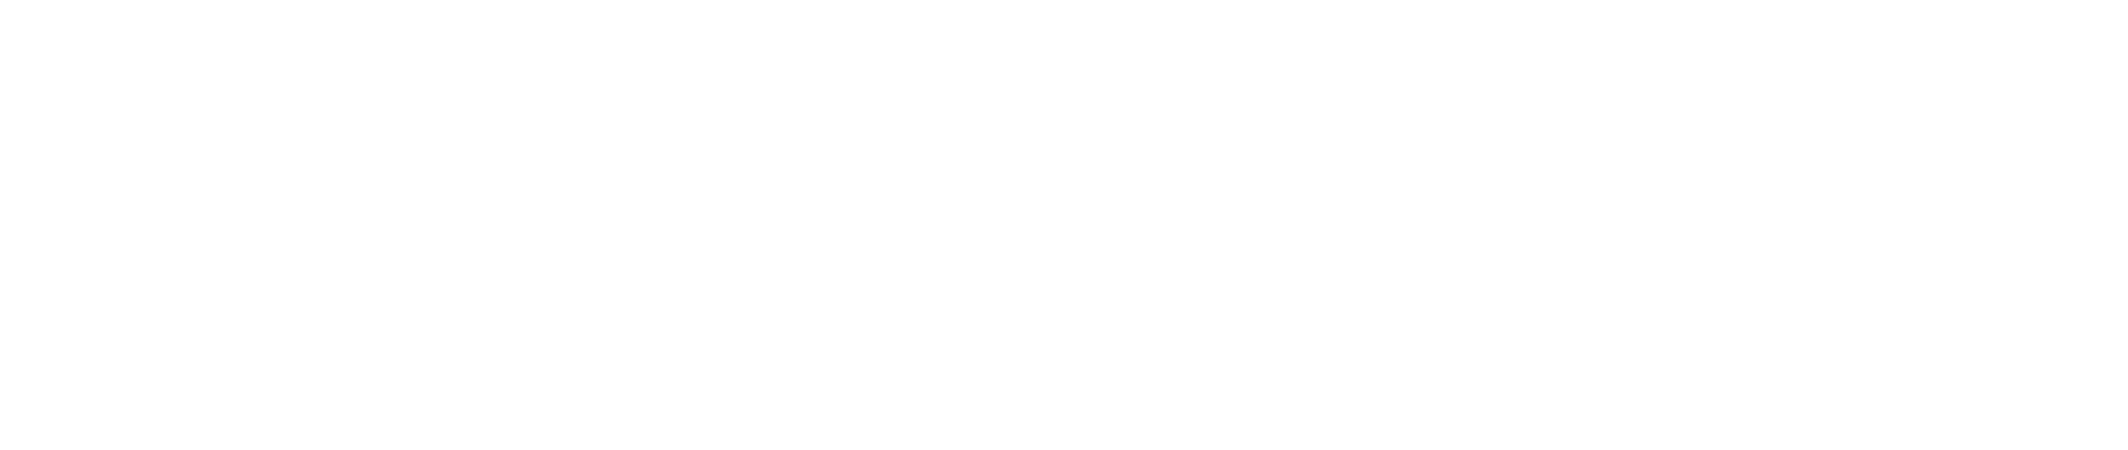

In [495]:
import plotly.graph_objects as go
import pandas as pd


def build_hierarchical_dataframe(df, levels, value_column, color_columns=None):
    """
    Build a hierarchy of levels for Sunburst or Treemap charts.

    Levels are given starting from the bottom to the top of the hierarchy,
    ie the last level corresponds to the root.
    """
    df_all_trees = pd.DataFrame(columns=['id', 'parent', 'value', 'color'])
    for i, level in enumerate(levels):
        df_tree = pd.DataFrame(columns=['id', 'parent', 'value', 'color'])
        # Aggregating by all levels to the right of current
        dfg = df.groupby(levels[i:]).sum()  # Aggregation Fanction
        dfg = dfg.reset_index()
        df_tree['id'] = dfg[level].copy()  #  Fill in ID column
        if i < len(levels) - 1:  # Setting PARENT value, the next column untill the last one, after which it is TOTAL
            df_tree['parent'] = dfg[levels[i+1]].copy()
        else:
            df_tree['parent'] = 'total'
        df_tree['value'] = dfg[value_column]
        df_tree['color'] = dfg[color_columns[0]] * 1.0 / dfg[color_columns[1]]
        df_all_trees = df_all_trees.append(df_tree, ignore_index=True)
    total = pd.Series(dict(id='total', parent='',
                              value=df[value_column].sum(),
                              color=df[color_columns[0]].sum() / df[color_columns[1]].sum()
                          )
                     )
    df_all_trees = df_all_trees.append(total, ignore_index=True)
    return df_all_trees



def plot_sunburst_static(df, value_column, levels = ['land', 'region_wb'], color_columns=['confirmed', 'population_100k'], value_column_name=''):
    
    hovertemplate = '<b>%{label} </b> <br> ' + value_column_name + ': %{value}<br>per 100k: %{color:.2f}'
    
    df_sunburst = build_hierarchical_dataframe(df, levels, value_column, color_columns)

    # average_score = df[column].mean()
    # min_score = df[column].min()
    # max_score = df[column].max()

    average_score = df_sunburst['color'].median()
    min_score = df_sunburst['color'].quantile(.1)
    max_score = df_sunburst['color'].quantile(.9)



    fig = go.Figure()

    fig.add_trace(go.Sunburst(
        labels=df_sunburst['id'],
        parents=df_sunburst['parent'],
        values=df_sunburst['value'],
        branchvalues='total',
        marker=dict(
#             colors=df_sunburst['color'],
            colorscale=colors.sequential.PuBu,
#             cmid=average_score,
#             cmax=max_score,
#             cmin=min_score
        ),
        hovertemplate=hovertemplate,
        name=''
        ))


    fig.update_layout(margin=dict(t=10, b=10, r=10, l=10))
    fig.show()

    
plot_sunburst_static(df.fillna(0), 'dead_change', levels = ['land', 'region_wb'], color_columns=['dead_change', 'population_100k'], value_column_name='Confirmed')

In [436]:
df['confirmed_change']

dates
2020-05-16     349.0
2020-05-16      17.0
2020-05-16     192.0
2020-05-16       0.0
2020-05-16       0.0
               ...  
2020-05-16     204.0
2020-05-16       0.0
2020-05-16       6.0
2020-05-16    1247.0
2020-05-16       9.0
Name: confirmed_change, Length: 186, dtype: float64

In [497]:
levels = ['land', 'region_wb'] # levels used for the hierarchical chart
# color_columns = ['sales', 'calls']
value_column = column


def build_hierarchical_dataframe(df, value_column,levels, color_columns=None):
    """
    Build a hierarchy of levels for Sunburst or Treemap charts.

    Levels are given starting from the bottom to the top of the hierarchy,
    ie the last level corresponds to the root.
    """
    df_all_trees = pd.DataFrame(columns=['id', 'parent', 'value', 'color'])
    for i, level in enumerate(levels):
        df_tree = pd.DataFrame(columns=['id', 'parent', 'value', 'color'])
        # Aggregating by all levels to the right of current
        dfg = df.groupby(levels[i:]).sum()  # Aggregation Fanction
        dfg = dfg.reset_index()
        df_tree['id'] = dfg[level].copy()  #  Fill in ID column
        if i < len(levels) - 1:  # Setting PARENT value, the next column untill the last one, after which it is TOTAL
            df_tree['parent'] = dfg[levels[i+1]].copy()
        else:
            df_tree['parent'] = 'total'
        df_tree['value'] = dfg[value_column]
        df_tree['color'] = dfg[color_columns[0]] * 1.0 / dfg[color_columns[1]]
        df_all_trees = df_all_trees.append(df_tree, ignore_index=True)
    total = pd.Series(dict(id='total', parent='',
                              value=df[value_column].sum(),
                              color=df[color_columns[0]].sum() / df[color_columns[1]].sum()
                          )
                     )
    df_all_trees = df_all_trees.append(total, ignore_index=True)
    return df_all_trees



df_sunburst = build_hierarchical_dataframe(df, 'dead', levels = ['land', 'region_wb'], color_columns=['dead', 'population_100k'])
df_sunburst.loc[df_sunburst.value < 0, 'value'] = 0



In [498]:
# df_sunburst2 = build_hierarchical_dataframe(df, 'dead', levels = ['land', 'region_wb'], color_columns=['dead', 'population_100k'])
# df_sunburst2

In [499]:
# df_sunburst.loc[df_sunburst.value < 0, 'value'] = 0
# df_sunburst

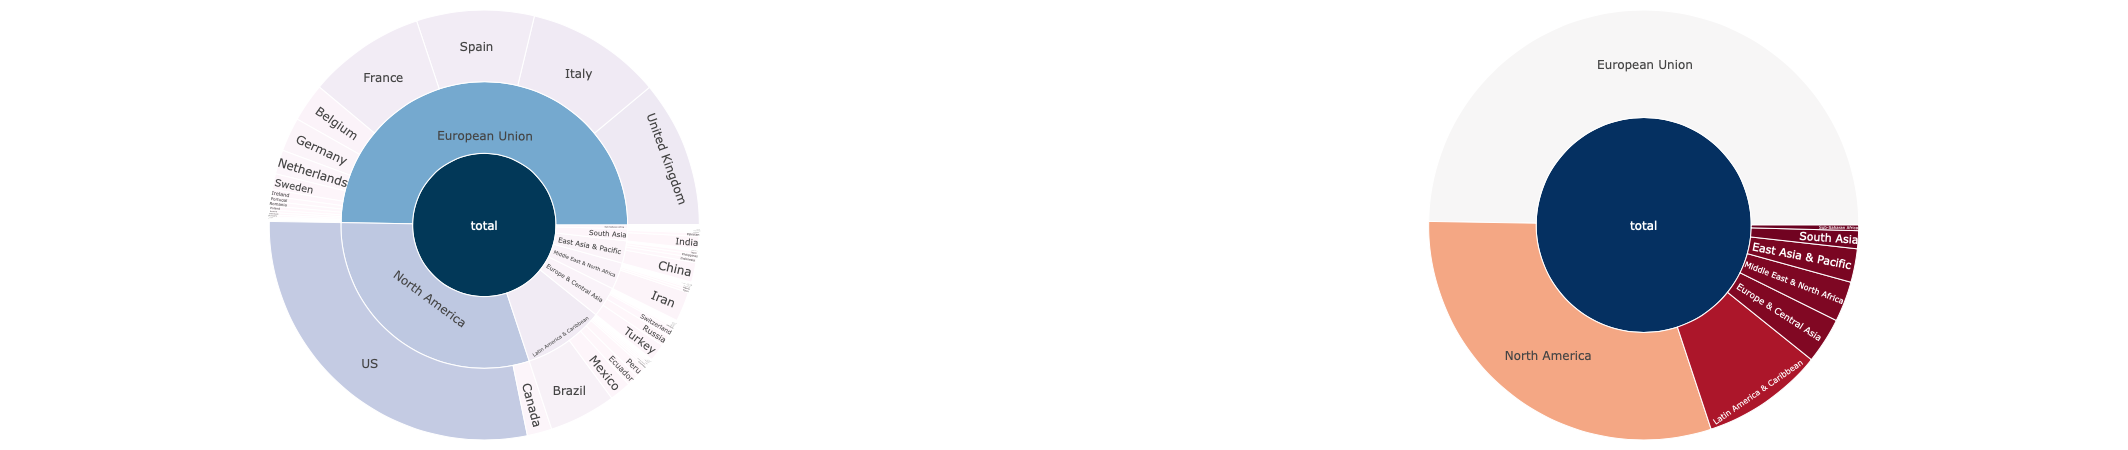

In [500]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

df = df_sunburst

# average_score = df[column].mean()
# min_score = df[column].min()
# max_score = df[column].max()

average_score = df['color'].median()
min_score = df['color'].quantile(.1)
max_score = df['color'].quantile(.9)



fig = make_subplots(1, 2, specs=[[{"type": "domain"}, {"type": "domain"}]],)

fig.add_trace(go.Sunburst(
    labels=df['id'],
    parents=df['parent'],
    values=df['value'],
    branchvalues='total',
    marker=dict(
#         colors=df_sunburst['color'],
        colorscale=colors.sequential.PuBu,
#         cmid=average_score,
#         cmax=max_score,
#         cmin=min_score
    ),
    hovertemplate='<b>%{label} </b> <br> Value: %{value}<br>Value per 100k: %{color:.0f}',
    name=''
    ), 1, 1)

fig.add_trace(go.Sunburst(
    labels=df['id'],
    parents=df['parent'],
    values=df['value'],
    branchvalues='total',
    marker=dict(
#         colors=df_sunburst['color'],
        colorscale='RdBu',
#         cmid=average_score,
#         cmax=max_score,
#         cmin=min_score
    ),
    hovertemplate='<b>%{label} </b> <br> Value: %{value}<br>Value per 100k: %{color:d}',
    maxdepth=2
    ), 1, 2)

fig.update_layout(margin=dict(t=10, b=10, r=10, l=10))
fig.show()

In [381]:
colors.sequential.PuBu

AttributeError: module 'plotly.colors' has no attribute 'colors'

In [310]:
# The sunburst plot requires weights (values), labels, and parent (region, or World)
# We build the corresponding table here
columns = ['parents', 'labels', 'values']
column_to_display = column
wld_count = df[column].sum()

level1 = df.loc[:, ['region_wb', 'land', column_to_display]].copy()
level1.columns = columns
level1['text'] = level1['values'].apply(lambda pop: '{:,.0f}'.format(pop))
# level1.head(1)

level2 = df.groupby('region_wb')[column_to_display].sum().reset_index()[['region_wb', 'region_wb', column_to_display]]
level2.columns = columns
level2['parents'] = 'World'

# move value to text for this level
level2['text'] = level2['values'].apply(lambda pop: '{:,.0f}'.format(pop))
level2['values'] = 0
# level2.head(1)

level3 = pd.DataFrame({'parents': [''], 'labels': ['World'],
                       'values': [0.0], 'text': ['{:,.0f}'.format(wld_count)]})
# level3.head(1)

all_levels = pd.concat([level1, level2, level3], axis=0).reset_index(drop=True)

# And now we can plot the World Population
go.iplot(dict(
    data=[dict(type='sunburst', hoverinfo='text', **all_levels)],
    layout=dict(title='World COVID-19 Total Cases<br>Click on a region to zoom',
                width=800, height=800)),
    validate=False)

AttributeError: module 'plotly.graph_objects' has no attribute 'iplot'